# Quantum Harmonic Oscillator as a two level system

Author(s): Pablo Giuliani, Kyle Godbey

Maintainer: Pablo Giuliani

Adapted from https://kylegodbey.github.io/nuclear-rbm/ho/1dHO.html with permision of Eric Flynn

## Background

Let us consider the Schrodinger equation for the 1-d Harmonic Oscillator:

\begin{align}
&\Big(- \frac{d^{2}}{dx^{2}} + V_\alpha (x)  - \lambda \Big) \phi = 0, \\
\end{align}
where $V_\alpha(x)=\alpha x^{2}$. This equation can be written a

\begin{align}
&F_{\alpha}\Big[ \phi_{\alpha}(x) \Big] = H_\alpha\phi - \lambda \phi=0 
\end{align}
where $\lambda = 2 m E$ is the eigenvalue with energy $E$ and $\alpha = m^{2} \omega^{2}$ is the harmonic oscilation parameter with oscilation frequency $\omega$. 

The shooting method and finite elements methods are among the many approaches to solve such types of equations using classical computers. During this notebook we will follow the finite element method, in which every object is projected onto a discretized space, the functions $\phi(x)$ becomes vectors, and the operators $H_\alpha$ matrices. These vectors and matrices could be composed of houndreds or thousands of elements, making it impossible to store such amount of information in a quantum computer with few qbits. For example, 7 qbits are available in the case of the free version of the IBM services. Therefore, if we want to implement an algorithm in a quantum circuit to find solutions to this equation for many values of the parameter $\alpha$ we need another strategy.  We approximate this equation using dimensionality reduction techniques, such as the [Reduced Basis Method](https://link.springer.com/book/10.1007/978-3-319-22470-1), as was done in [this book](https://kylegodbey.github.io/nuclear-rbm/ho/1dHO.html). These techniques aim at reducing the redundant, or unnecessary, degrees of freedom of the system from many thousand to just a handful. This is done by first restricting the solution to the equation to lay in the span of a basis of $n$ states:
\begin{align}
\hat{\phi}_{\alpha}(x) = \sum_{i=1}^{n} a_{i} \phi_{i}(x) 
\end{align}
where $\phi_{i}(x)$ are informed on previous solutions built on a classical computer to the Schrodinger equation for chosen values of $\alpha$.

## Finite element method approach

In [22]:
import numpy as np
import scipy as sci
from scipy import optimize
from scipy import special
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])

We first define some helper functions to return things like the potentials and Hamiltonian.

In [23]:
### NOTE: hbar = 1 in this demo
### First define exact solutions to compare numerical solutions to.
def V(x,alpha):
    '''
    1-d harmonic Oscillator potential

    Parameters
    ----------
    x : float or nd array
        position.
    alpha : float
        oscillator length parameter.

    Returns
    -------
    float or ndarray
        value of potential evaluated at x.

    '''
    return alpha*x**2
def construct_H(V,grid,mass,alpha):
    '''
    Uses 2nd order finite difference scheme to construct a discretized differential H operator
    Note: mass is fixed to 1 for this demo.

    Parameters
    ----------
    V : TYPE
        DESCRIPTION.
        
    alpha : TYPE
        oscillator parameter alpha used in V(x) = alpha*x**2.

    Returns
    -------
    H : ndarray
        2d numpy array
    '''
    dim = len(grid)
    off_diag = np.zeros(dim)
    off_diag[1] = 1
    H = -1*(-2*np.identity(dim) + sci.linalg.toeplitz(off_diag))/(mass*h**2) + np.diag(V(grid,alpha))
    return H
def solve(H,grid,h):
    '''
    Parameters
    ----------
    H : 2d ndarray
        Hamiltonian Matrix.
    grid : ndarray
        Discretized 1d domain.
    h : float
        grid spacing.

    Returns
    -------
    evals : ndarray
        returns nd array of eigenvalues of H. 
    evects : ndarray
        returns ndarray of eigenvectors of H.
    Eigenvalues and eigenvectors are ordered in ascending order. 
    '''
    evals,evects = np.linalg.eigh(H)
    evects = evects.T
    for i,evect in enumerate(evects):
        #norm = np.sqrt(1/sci.integrate.simpson(evect*evect,grid))
        norm = 1/(np.linalg.norm(np.dot(evect,evect)))
        evects[i] = evects[i]*norm/np.sqrt(h)
    return evals,evects

def getSystem(H,psi_array,phi_array):
    '''
    Sets up system of equations for Galerkin projection <\phi_{j},F_{k}(phi_{k})>

    Parameters
    ----------
    H : ndarray
        Hamiltonian matrix.
    psi_array : ndarray
        array of projector functions. Assumes rows are corresponding to discretized functions
    phi_array : TYPE
        DESCRIPTION.

    Returns
    -------
    Function
        Function that takes in a vector of parameters of the form (a_{1},a_{2},....,\lambda_{\alpha}) 
        and outputs of the system of equations. \lambda_{\alpha} is the eigenvalue of HO equation.
    '''
    ## 
    def system(a_vec):
        '''
        Parameters
        ----------
        a_vec : ndarray
            vector of parameters (a_{k},\lambda).

        Returns
        -------
        results : ndarray
            outputs of the Galerkin projection equations and normalization functions <\hat{\phi}|\hat{\phi}> = 1.
            This systems can be solved using sci.optimize.fsolve or using your choice of method.
        '''
        results = np.zeros(len(a_vec))
        results[-1] = -1 # from normalization
        for i in np.arange(0,len(a_vec)-1,1):
            for k in np.arange(0,len(a_vec)-1,1):
                results[i] += a_vec[k]*np.dot(psi_array[i],np.matmul(H,phi_array[k])) - \
                a_vec[-1]*a_vec[k]*np.dot(psi_array[i],phi_array[k])
        for k in np.arange(0,len(a_vec)-1,1):
            for kp in np.arange(0,len(a_vec)-1,1):
                results[-1] += a_vec[kp]*a_vec[k]*np.dot(psi_array[kp],phi_array[k])
        return results
    return system

Now we can define some parameters of our system, including our mesh.

In [24]:
#First define global variables
h = 10**(-1) ### grid spacing for domain (Warning around 10**(-3) it starts to get slow).
### HO global parameters 
n = 0 # principle quantum number to solve in HO
mass = 1.0 # mass for the HO system
# define the domain boundaries
x_a = -10 # left boundary 
x_b = 10 # right boundary 
x_array = np.arange(x_a,x_b+h,h)
m = len(x_array) 
print('Number of grid points: ',m)

Number of grid points:  201


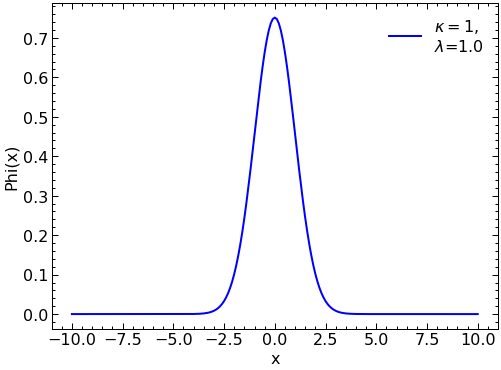

In [25]:
H = construct_H(V,x_array,1,1) 
evals, evects = solve(H,x_array,h) 

plt.plot(x_array, evects[0], color="blue",label = r'$\kappa=1,$' "\n" '$\lambda$='+str(round(evals[0],2)))

plt.legend(loc='upper right')

plt.ylabel("Phi(x)")
plt.xlabel("x")
plt.show()

## The Reduced Basis Method approach

### Construction of the Reduced Basis

Now we select a set of values of $\alpha$ to solve with the finite element method. These solutions will be used as the basis in the reduced basis model.

In [26]:
# Select alpha values to use to solve SE exactly.
alpha_vals = [.5,1,2,5,15]  #Here, we choose 3 values of alpha to solve exactly. This results in 3 basis functions
# initialize solution arrays. T is the matrix that will hold wavefunction solutions. 
# T has the form T[i][j], i = alpha, j = solution components
T = np.zeros((len(alpha_vals),m)) 
# T_evals holds the eigenvalues for each evect in T. 
T_evals = np.zeros(len(alpha_vals))

alpha = 0.5, lambda = 0.7067941428963106
alpha = 1, lambda = 0.9993746086404902
alpha = 2, lambda = 1.4129624545775548
alpha = 5, lambda = 2.23293859175503
alpha = 15, lambda = 3.8635854863645682


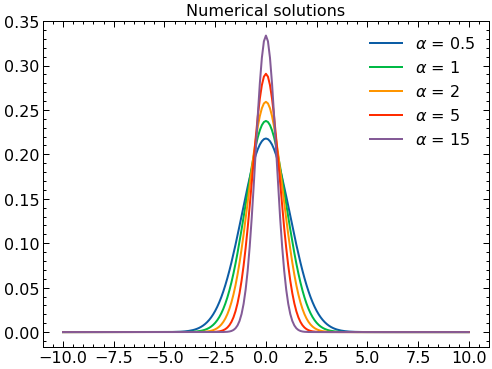

In [27]:
for i,alpha_sample in enumerate(alpha_vals):
    H = construct_H(V,x_array,mass,alpha_sample) # construct the Hamiltonian matrix for given alpha_sample.
    evals, evects = solve(H,x_array,h) # solve the system for evals and evects.
    T[i] = evects[n]/np.linalg.norm(evects[n]) # assign the nth evect to solution array T
    T_evals[i] = evals[n] # assign the nth eigenvalue to the eigenvalue array T_eval.
    print(f'alpha = {alpha_sample}, lambda = {evals[n]}')
    

    

# Make plots of the numerical wavefunction 
fig, ax = plt.subplots(1,1)
for i in range(len(alpha_vals)):
    
    ax.plot(x_array,(T[i]),label=r'$\alpha$ = '+str(alpha_vals[i]))

ax.set_title('Numerical solutions')

ax.legend()

plt.show()



### Proper Orthogonal Decomposition

After obtained a sample of what the solutions look like for some values of the parameters we proceed now to construct our basis with two elements. These elements will be selected as the first two principal components of a [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), also related to [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition). This procedure aims at capturing the two components that can better explain (in a linear way) the variability among our samples. In the Reduced Basis Methods community it is known as Proper Orthogonal Decompositon.

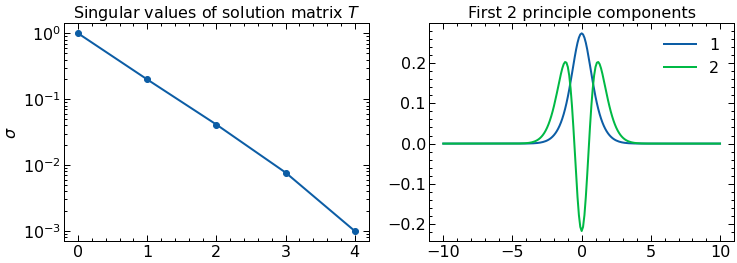

In [28]:
U, s, Vh = np.linalg.svd(T)
phi1=-1*Vh[0] #multiplying by -1 so they are positive at x=0, not necessary but the plots look better
phi2=-1*Vh[1]
n_comps = 2 # number of principle components to plot (i.e number of column vectors of SVD matrix V to plot)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].semilogy(s/s[0],'o-')
ax[0].set_title(r'Singular values of solution matrix $T$')
ax[0].set_ylabel(r'$\sigma$')

ax[1].plot(x_array,phi1,label=str(1))
ax[1].plot(x_array,phi2,label=str(2))
ax[1].set_title(f'First {n_comps} principle components')
ax[1].legend()
plt.show()


### Effective two level system "Hamiltonian"
We will now model an effective hamiltonian in which two "particles" interact, each one represents one of these two components.

Here we explicitly construct $ \hat{\phi}_{\alpha}= a_{1} \phi_{1}+a_2\phi_2$ and use the Galerkin method, that is, projecting $F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big)$ over $2$ linearly independent functions projecting functions $\{ \psi_{i}\}_{i=1}^{2}$. 

\begin{align}
&\langle \psi{1}| F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big) \rangle = 0 \\
&\langle \psi{2}| F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big) \rangle = 0 
\end{align}

We can interpret this as enforcing the orthogonality of $F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big)$ to the subspace spanned by $\{\psi_{i}\}$ that is, by finding $\hat{\phi}_{\alpha}$ such that $F_{\alpha}(\hat{\phi}_{\alpha})$ is approximately zero up to the ability of the set $\{\psi_{i}\}$. The choice of projecting functions $\{ \psi_{i} \}$ is arbitrary, but here we choose the solution set $\{ \phi_{i} \}$ to be our projecting functions to make our lives easier. Since $\lambda$ is also unknown, we need an additional equation. This comes from the normalization conditions:

\begin{align}
\langle \hat{\phi}_{\alpha_{k}}|\hat{\phi}_{\alpha_{k}} \rangle  = 1
\end{align}

We can re-write the projecting equations taking advantage of the linear form of $F_\alpha$ to obtain an effective 2-level system Hamiltonian. We note that:

\begin{align}
&\langle \phi_{i}| F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big) \rangle =  \\
&\langle \phi_{i}|  a_1 H_\alpha \phi_1 + a_2 H_\alpha \phi_2 - a_1\hat \lambda \phi_1 - a_2\hat \lambda \phi_2\rangle
\end{align}

Since $\langle \phi_i|\phi_j\rangle = \delta _{i,j}$, we arrive at the following matrix equation for the projecting equations:

\begin{equation}
\tilde H_\alpha |a\rangle = \hat\lambda |a\rangle
\end{equation}

where $|a\rangle = \{a_1,a_2\}$ and 

\begin{equation}
\tilde H_\alpha = \begin{bmatrix} \langle \phi_1|H_\alpha|\phi_1\rangle & \langle \phi_1|H_\alpha|\phi_2\rangle \\ \langle \phi_2|H_\alpha|\phi_1\rangle & \langle \phi_2|H_\alpha|\phi_2\rangle \end{bmatrix}
\end{equation}

while the normalization condition translates into:

\begin{equation}
\langle a|a \rangle  = a_1^2+a_2^2= 1
\end{equation}


Now we proceed to construct this Hamiltonian matrix for our problem at hand. We note that although $\tilde H_\alpha$ depends on $\alpha$, the dependance is only in the potential part and it is affine (linear): $H_\alpha=H_0+\alpha H_1$, where $H_0= - \frac{d^{2}}{dx^{2}}$ and $H_1= x^2$. We then decompose $\tilde H_\alpha= \tilde H_0 + \alpha \tilde H_1$. We now construct these matrices:

In [29]:
dim0 = len(x_array)
off_diag = np.zeros(dim0)
off_diag[1] = 1

H0=-1*(-2*np.identity(dim0) + sci.linalg.toeplitz(off_diag))/(mass*h**2) 
H1=np.diag(V(x_array,1))

tildeH0=np.array([[0.0,0.0],[0.0,0.0]])
tildeH1=np.array([[0.0,0.0],[0.0,0.0]])

tildeH0[0][0]=np.dot(phi1,np.dot(H0,phi1))
tildeH0[0][1]=np.dot(phi1,np.dot(H0,phi2))
tildeH0[1][0]=np.dot(phi2,np.dot(H0,phi1))
tildeH0[1][1]=np.dot(phi2,np.dot(H0,phi2))

tildeH1[0][0]=np.dot(phi1,np.dot(H1,phi1))
tildeH1[0][1]=np.dot(phi1,np.dot(H1,phi2))
tildeH1[1][0]=np.dot(phi2,np.dot(H1,phi1))
tildeH1[1][1]=np.dot(phi2,np.dot(H1,phi2))

print(tildeH0)
print(tildeH1)


[[ 0.7770743  -1.240322  ]
 [-1.240322    4.30501452]]
[[0.33343621 0.51501739]
 [0.51501739 1.49714625]]


With these two Hamiltonians, we can then combine them according to the equation above via these helper functions.

In [30]:
def tildeH(alpha):
    return tildeH0+alpha*tildeH1

def systemSolver(alpha):
    resultssystem= np.linalg.eig(tildeH(alpha))
    if resultssystem[1][0][0]<0:
        resultssystem[1][0]=resultssystem[1][0]*(-1)
    if resultssystem[1][1][0]<0:
        resultssystem[1][1]=resultssystem[1][1]*(-1)   
    return resultssystem

def phibuilder(alpha):
    coefficients=systemSolver(alpha)[1][0]
    return coefficients[0]*phi1+coefficients[1]*phi2

Let's print out our total Hamiltonian given $\alpha=3$

In [31]:
tildeH(3)

array([[1.77738292, 0.30473019],
       [0.30473019, 8.79645327]])

Looks great! Now we can compute the coefficients of our basis functions via direct diagonalization, again with $\alpha=3$.

In [32]:
solution = systemSolver(3)
print("Eigenvalues: ", solution[0])
print("a1 Coefficient: ",solution[1][0][0])
print("a2 Coefficient: ",solution[1][0][1])

Eigenvalues:  [1.76417802 8.80965817]
a1 Coefficient:  0.9990624419940102
a2 Coefficient:  0.04329245889257087


Now we try our solution solver against the finite element computation to see how well our RBM solution is doing.

alpha = 3, lambda = 1.7301737711983323


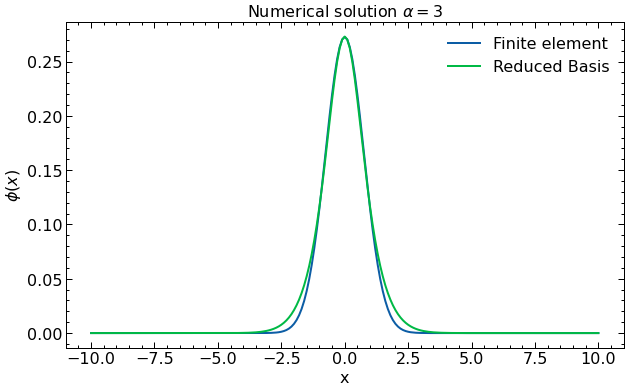

In [33]:
# Now we can construct our RBM for an alpha of our choosing. 
alpha_k = 3
solGaler=phibuilder(alpha_k)
lamGaler=systemSolver(alpha_k)[0][0]

alpha_vals = [alpha_k]  

T = np.zeros((len(alpha_vals),m)) 
 
T_evals = np.zeros(len(alpha_vals))

for i,alpha_sample in enumerate(alpha_vals):
    H = construct_H(V,x_array,mass,alpha_sample) # construct the Hamiltonian matrix for given alpha_sample.
    evals, evects = solve(H,x_array,h) # solve the system for evals and evects.
    T[i] = evects[n]/np.linalg.norm(evects[n]) # assign the nth evect to solution array T
    T_evals[i] = evals[n] # assign the nth eigenvalue to the eigenvalue array T_eval.
    print(f'alpha = {alpha_sample}, lambda = {evals[n]}')
    

    

# Make plots of the numerical wavefunction 
fig, ax = plt.subplots(1,1,figsize=(10,6))
for i in range(len(alpha_vals)):
    
    ax.plot(x_array,(T[i]),label= r'Finite element')

ax.plot(x_array,(phi1),label=r'Reduced Basis')    
    


ax.set_title('Numerical solution ' r'$\alpha=$'+str(alpha_vals[i]))

ax.legend()
plt.ylabel(r'$\phi(x)$')
plt.xlabel("x")
ax.legend()
plt.show()



Excellent! Of course, if we take more basis functions we will better reproduce the finite element solution, but the procedure remains largely the same. Now that we've laid the groundwork for representing our complicated coordinate space problems in a natural reduced basis, we can explore how this translates to a representation on a quantum computer.

Before that, we make a final comment in regards to approximations such as the reduced basis method. We are using a basis of two elements $\phi_1$ and $\phi_2$ in which we believe $\phi_1$ captures most of the dynamics of the system as $\alpha$ changes, while $\phi_2$ accounts for small corrections. This is due to how we built the basis throught the Principal Component Analysis. A great advantage of such procedure is that, if the coefficient associated with $\phi_2$ starts becoming large, that will signal that our approximation is deteriorating and that more basis states would be needed for a correct representation of the underlying system. Give it a try, can you choose a parameter $\alpha$ way beyond what we have been using and see what happens with the coefficients $a_1$ and $a_2$?